*Dodać tu wstęp i td.*
1
1
1
1
1

In [18]:
from pprint import pprint

import os
import re
import time
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import sklearn
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted

random_state = 123


In [19]:
# Wczytywanie danych

def load_data(dataset):
    data = pd.read_csv(dataset)
    return data['text'].values, data['label'].values

X_train, y_train = load_data('emotion-labels-train.csv')
X_test, y_test = load_data('emotion-labels-test.csv')
X_val, y_val = load_data('emotion-labels-val.csv')

print(X_train)
print(y_train)

['Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'
 "Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂"
 'Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️' ...
 "@SilkInSide @TommyJoeRatliff that's so pretty! I love the sky in the background and the purple highlights with the dull colors is great"
 '@BluesfestByron second artist announcement looking good #bluesfest2017 #blues #Music #byronbay'
 'I can literally eat creamy pesto pasta topped with grilled chicken, sun dried tomatoes, asparagus and pine nuts every single day of my life']
['joy' 'joy' 'joy' ... 'sadness' 'sadness' 'sadness']


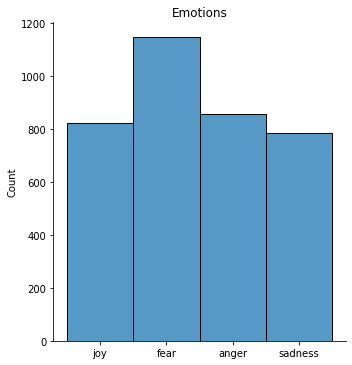

In [20]:
# Szybka analiza danych

sns.displot(y_train)
plt.title('Emotions')
plt.show()


Zróbmy teraz szybki ML test kilku klasyfikatorów, i zobaczmy jaką accuracy dostaniemy.

In [32]:
def test_classifiers(classifiers, X, y):
    best_classifier = None
    best_score = 0
    for _clf in classifiers:
        try:
            clf = sklearn.clone(_clf)
            scores = cross_val_score(clf, X, y)

            print('Using classifier:', clf)
            print('\tscores:', scores)
            print('\tbest:', np.max(scores))
            print('\taverage:', np.average(scores))

            max_score = np.average(scores)
            if max_score > best_score:
                best_score = max_score
                best_classifier = clf
                
        except Exception as e:
            print('*** FAIL ***', _clf)
            print(e)

    print('Fitting best classifier')
    best_classifier.fit(X, y)
    y_pred = best_classifier.predict(X)

    conf_matrix = confusion_matrix(y, y_pred, normalize='true')

    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.5f')
    plt.show()

    return best_classifier, best_score


Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious
  (0, 4798)	1
  (0, 3769)	1
  (0, 842)	1
  (0, 3488)	2
  (0, 7917)	1
  (0, 3593)	1
  (0, 4383)	1
  (0, 1434)	1
  (0, 507)	1
  (0, 3093)	1
  (0, 8504)	1
  (0, 4271)	1
  (0, 5051)	1
  (0, 8264)	1
  (0, 5921)	1
  (0, 4114)	1
Using classifier: KNeighborsClassifier()
	scores: [0.36791148 0.3582296  0.41493776 0.39196676 0.36426593]
	best: 0.4149377593360996
	average: 0.37946230503097667
Using classifier: LinearSVC(max_iter=10000, random_state=123)
	scores: [0.83679115 0.85477178 0.85338866 0.8365651  0.79916898]
	best: 0.8547717842323651
	average: 0.836137132523381
Using classifier: RandomForestClassifier(n_jobs=8, random_state=123)
	scores: [0.84370678 0.85615491 0.83264177 0.81024931 0.77146814]
	best: 0.8561549100968188
	average: 0.8228441818676414
Fitting best classifier


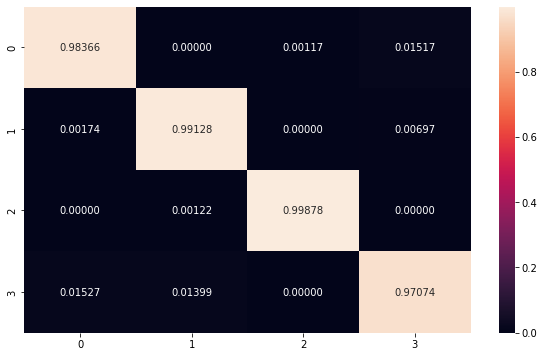

Best classifier is: LinearSVC(max_iter=10000, random_state=123) 0.836137132523381


In [33]:
classifiers = [
    KNeighborsClassifier(),
    LinearSVC(max_iter=10000, random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=8),
]
prep_pipeline = Pipeline([
    ('vectorizer', CountVectorizer())
])

X_train_transformed = prep_pipeline.fit_transform(X_train)
print(X_train[0])
print(X_train_transformed[0])

best_clf, best_score = test_classifiers(classifiers, X_train_transformed, y_train)
print('Best classifier is:', best_clf, best_score)

Zróbmy preprocessing - zmodyfikujmy tweet'y w następujący sposób:

- Usunięcie tegów (@name)
- Usunięcie zakodowanych wartości (np. &amp;).
- Konwersja emoji na tokeny (są one dobrą reprezentacją tego emoji, ale są filtrowane przez tokenizer).

In [35]:
class RemoveTags(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = pd.Series(X)
        return values.replace(r'@\w+', '', regex=True).values

remove_tags = RemoveTags()
print(remove_tags.fit_transform(X_train[:10]))

['Just got back from seeing  in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'
 "Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂"
 'Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️'
 " : Thank you so much, Gloria! You're so sweet, and thoughtful! You just made my day more joyful! I love you too! 😊💕"
 'I feel so blessed to work with the family that I nanny for ❤️ nothing but love &amp; appreciation, makes me smile.'
 'Today I reached 1000 subscribers on YT!! , #goodday, #thankful'
 " Good morning, love! Happy first day of fall. Let's make some awesome #autumnmemories #annabailey #laughter #smile"
 "#BridgetJonesBaby is the best thing I've seen in ages! So funny, I've missed Bridget! #love  #TeamMark"
 'Just got back from seeing  in Burslem. AMAZING!! Face still hurts from laughing so much '
 ' I thought the holidays could not get any more cheerful, and then I met you. #TheNiceBot']


In [39]:
class RemoveCodedValues(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = pd.Series(X)
        return values.replace(r'&\w+;', '', regex=True).values

remove_coded_values = RemoveCodedValues()

pat = re.compile(r'&\w+;')

print(remove_coded_values.fit_transform(X_train[:10]))

['Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'
 "Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂"
 'Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️'
 "@gardiner_love : Thank you so much, Gloria! You're so sweet, and thoughtful! You just made my day more joyful! I love you too! 😊💕"
 'I feel so blessed to work with the family that I nanny for ❤️ nothing but love  appreciation, makes me smile.'
 'Today I reached 1000 subscribers on YT!! , #goodday, #thankful'
 "@Singaholic121 Good morning, love! Happy first day of fall. Let's make some awesome #autumnmemories #annabailey #laughter #smile"
 "#BridgetJonesBaby is the best thing I've seen in ages! So funny, I've missed Bridget! #love  #TeamMark"
 'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much '
 '@IndyMN I thought the holidays could not get any more cheerful, and 

In [41]:
class TokenizeEmoji(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([emoji.demojize(text) for text in X])

vectorizer = CountVectorizer()
tokenize_emoji = TokenizeEmoji()
test = tokenize_emoji.fit_transform(X_train[:10])

vectorizer.fit(test)


CountVectorizer()

Testing pipeline with new changes

Using classifier: KNeighborsClassifier()
	scores: [0.39142462 0.40387275 0.43430152 0.36842105 0.3601108 ]
	best: 0.4343015214384509
	average: 0.3916261498909974
Using classifier: LinearSVC(max_iter=10000, random_state=123)
	scores: [0.83264177 0.86168741 0.84232365 0.82963989 0.77839335]
	best: 0.8616874135546335
	average: 0.8289372152810506
Using classifier: RandomForestClassifier(n_jobs=8, random_state=123)
	scores: [0.83817427 0.86721992 0.83540802 0.82132964 0.79085873]
	best: 0.8672199170124482
	average: 0.8305981157304705
Fitting best classifier


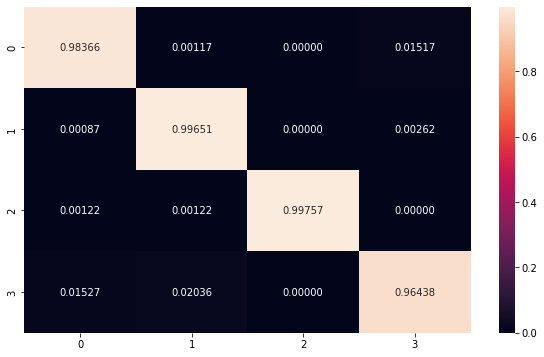

In [46]:
pipeline = Pipeline([
    ('handles', RemoveTags()),
    ('coded', RemoveCodedValues()),
    ('emoji', TokenizeEmoji()),
    ('counts', CountVectorizer())
])

prepared_X_train = pipeline.fit_transform(X_train)

best_clf, score = test_classifiers(classifiers, prepared_X_train, y_train)

In [49]:
def predict_emotion(text, classifier, pipeline):
    preprocessed_text = pipeline.transform([text])
    emotion = classifier.predict(preprocessed_text)[0]
    return emotion

# Example usage
text = "I'd love to see you again!"
predicted_emotion = predict_emotion(text, best_clf, pipeline)
print("Predicted Emotion:", predicted_emotion)


Predicted Emotion: fear
